# Multirate DSP

Multirate signal processing is the study and implementation of concepts, algorithms, and architectures that embed sample rate changes at one or more places in the signal data flow. Multirate signal processing is a subset of Digital Signal Processing (DSP) as we primarily deal with sampled, discrete systems (rather than analog, continuous-time systems). The two main reasons to implement Multirate signal processing in a design are:
1. Reducing the cost of design implementation
2. Enhancing the performance of the implementation

Some of the common tenets of Multirate DSP are:
* A processing task should always be performed at the lowest rate commensurate with the signal bandwidth (the Nyquist rate of the signal of interest (SOI))
* To achieve the above, Multirate DSP often deals with interchanging traditional DSP processing stages, and accepting intentional aliasing, by use of the _Noble Identity_ 

For example, a common DSP task is to reduce the bandwidth of a sampled signal to isolate a SOI (e.x. using a low-pass filter (LPF)), and then reduce the sample rate to match the SOI's bandwidth. However with the Noble Identity, we can reduce the sample rate first, and then perform the filtering at the lower sample rate (and often with a lower order filter compared to it processing at the higher sample rate). This intentional aliasing can be unwrapped by the subsequent Multirate processing. This powerful tool can even be used to intentionally alias a signal from one center frequency to another (e.g. from an Intermediate Frequency (IF) to baseband) while reducing sample rate.

In [ ]:
from IPython.display import YouTubeVideo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy import signal

from rfproto import filter, multirate, plot, sig_gen, utils

## Sample Rate Conversion

### Downsampling

Also known as _decimation_ (though technically the "deci" was a historical term to "remove every tenth one"), _downsampling_ is the process of reducing the sample rate of a system. To downsample by an integer factor $M$, we can simply keep every $M$th sample from an input stream, discarding the rest.

$$ y[m] = x[n]|_{n=mM}\quad \text{for } n=0,1,2,\cdots N;\quad m=0,1,2,\cdots \frac{N}{M} $$

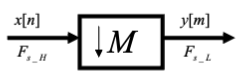

In [ ]:
f_start = 20e3
f_end = 25e3
fs = 100e3
num_samples = 16384

lfm_chirp_sig = sig_gen.cmplx_dt_lfm_chirp(1, f_start, f_end, fs, num_samples)
lfm_chirp_sig = lfm_chirp_sig.real + 1j*np.zeros(num_samples)
plot.spec_an(lfm_chirp_sig, fs, fft_shift=True, show_SFDR=False)
plt.show()

In [ ]:
M = 4
y_ds = multirate.decimate(lfm_chirp_sig, M)
plot.spec_an(y_ds, fs/M, fft_shift=True, show_SFDR=False)
plt.show()

### Upsampling

_Upsampling_ is the opposite of downsampling and is the process of _increasing_ the sample rate of a system. To upsample by an integer factor $L$, we can insert $L-1$ zeros between every sample from an input stream.

$$ y[n] = x[m]|_{m=n/L} $$

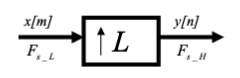

In [ ]:
f_start = -5e3
f_end = 5e3
fs = 100e3
num_samples = 16384

lfm_chirp_sig = sig_gen.cmplx_dt_lfm_chirp(1, f_start, f_end, fs, num_samples)
plot.spec_an(lfm_chirp_sig, fs, fft_shift=True, show_SFDR=False)
plt.show()

In [ ]:
L = 4
y_us = multirate.interpolate(lfm_chirp_sig, L)
plot.spec_an(y_us, fs*L, fft_shift=True, show_SFDR=False)
plt.show()

### Noble Identities

The _noble identity_ in multirate DSP allows us to commute resampling operations. Since down and upsamplers are Linear Time-Varying (LTV) processes, the order of operations matter- moving a $N$ downsampler through a filter $H(z)$ is equivalent to a filter $H(z^{N})$ followed by the $N$ downsampling operation. The primary use of this identity is to allow processing of multirate functions (e.x. filtering) at the ideal/efficient sample rate:

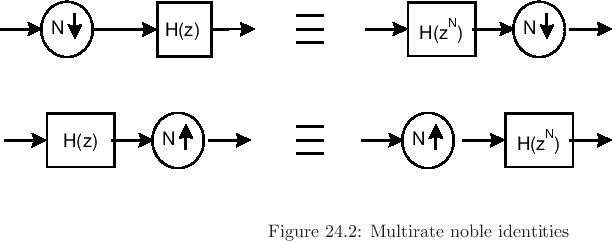

Memoryless operations (e.x. adders, multipliers) may be commuted across down and upsamplers as well:

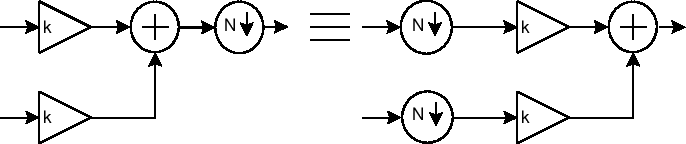

[From JOS](https://ccrma.stanford.edu/~jos/sasp/Multirate_Noble_Identities.html)

## Polyphase Filtering

### Polyphase Filters

In [ ]:
M = 5
N = 20 * M # Number of filter taps
fs = 48e3 # sampling frequency (Hz)
w_delta = np.pi/100 # transition bandwidth
wp = ((np.pi/M) - w_delta)/np.pi # passband
ws = ((np.pi/M) + w_delta)/np.pi # stopband

# NOTE: vs MATLAB `firpm` which specifies band egdes from 0->fs, 
#  scipy.signal.remez() uses bands 0->fs/2
taps = signal.remez(N, [0, wp*fs/2, ws*fs/2, fs/2], [1, 0], fs=fs)
plot.filter_response(taps)
plot.plt.show()

pb_ripple, sb_atten = filter.measure_filter_response(taps, 0.0, wp, ws, 1.0)
print(f"Passband ripple: {pb_ripple} dB | Stopband attenuation: {sb_atten} dB")

In [ ]:
h_poly = taps.reshape(len(taps)//M, M).T

# generate x indices
xi = np.zeros_like(h_poly)
color = iter(cm.rainbow(np.linspace(0, 1, M)))
for i in range(M):
    xi[i] = list(range(i, N, M))
    plt.stem(xi[i], h_poly[i], cm.viridis(i/M), label=f"h[{i}]")

plt.legend()
plt.show()

It can be seen that the response of each polyphase leg is _allpass_ with _linear phase_ from $0 \rightarrow f_{s}$.

In [ ]:
fig, axs = plt.subplots(2, 1, layout='constrained')
for i in range(M):
    wi, hi = signal.freqz(h_poly[i])
    axs[0].plot(wi / np.pi, utils.mag_to_dB(M * hi), linewidth=0.5, label=f"h[{i}]")
    axs[1].plot(wi / np.pi, np.unwrap(np.angle(hi)), linewidth=0.5, label=f"h[{i}]")

axs[0].set_ylabel("Amplitude (dB)")
axs[0].set_xlabel(r"Normalized Frequency ($\times \pi$ rad/sample)", fontsize=12)
axs[0].margins(x=0)
axs[0].legend()
axs[1].set_ylabel("Angle (radians)")
axs[1].set_xlabel(r"Normalized Frequency ($\times \pi$ rad/sample)", fontsize=12)
axs[1].margins(x=0)
axs[1].legend()
plt.show()

### Polyphase Filter Banks (PFBs) and Channelizers

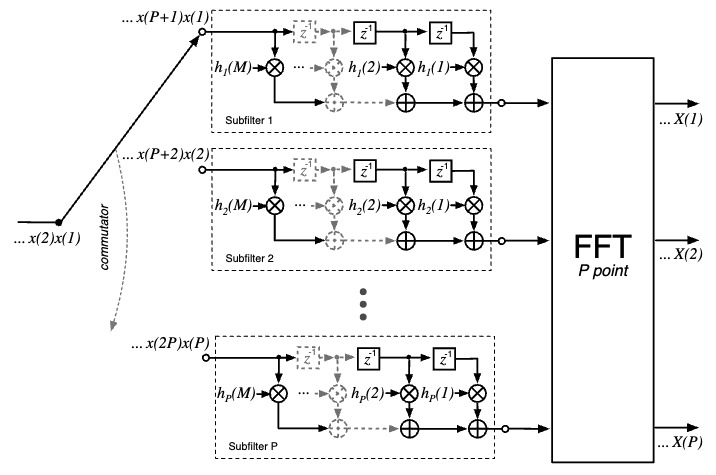

#### PFB References

* [Xilinx XAPP1161 Polyphase Filter Bank Channelizer, v1.0, Application Note](https://docs.amd.com/v/u/en-US/xapp1161)
* [Spectrometers and Polyphase Filterbanks in Radio Astronomy - Danny C. Price - arXiv](https://arxiv.org/pdf/1607.03579)
  + [Associated Jupyter Notebook](https://github.com/telegraphic/pfb_introduction/blob/master/pfb_introduction.ipynb)

In [ ]:
YouTubeVideo('WRO9VD6MYy4')

### Polyphase Filter References

* [A Review of Polyphase Filter Banks and Their Application - DTIC AFRL](https://apps.dtic.mil/sti/tr/pdf/ADA457390.pdf)
* [Polyphase Filters and Filterbanks - Kyle](https://www.dsprelated.com/showarticle/191.php)
  + [polyphase-signal-processing.ipynb - Colaboratory](https://colab.research.google.com/github/kastnerkyle/kastnerkyle.github.io/blob/master/posts/polyphase-signal-processing/polyphase-signal-processing.ipynb)

In [ ]:
YouTubeVideo('Zmjk9NE-3k0')

In [ ]:
YouTubeVideo('afU9f5MuXr8')